In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('houses_Madrid.csv')  # Adjust filename if needed

print("=== MADRID REAL ESTATE DATASET ===")
print(f"Total Properties: {len(df):,}")
print(f"Columns: {len(df.columns)}")

print("\n=== COLUMN NAMES ===")
print(df.columns.tolist())

print("\n=== FIRST FEW PROPERTIES ===")
print(df.head())

print("\n=== DATA TYPES ===")
print(df.dtypes)

print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

=== MADRID REAL ESTATE DATASET ===
Total Properties: 20,355
Columns: 58

=== COLUMN NAMES ===
['Unnamed: 0', 'id', 'title', 'subtitle', 'sq_mt_built', 'sq_mt_useful', 'n_rooms', 'n_bathrooms', 'n_floors', 'sq_mt_allotment', 'latitude', 'longitude', 'raw_address', 'is_exact_address_hidden', 'street_name', 'street_number', 'portal', 'floor', 'is_floor_under', 'door', 'neighborhood_id', 'operation', 'rent_price', 'rent_price_by_area', 'is_rent_price_known', 'buy_price', 'buy_price_by_area', 'is_buy_price_known', 'house_type_id', 'is_renewal_needed', 'is_new_development', 'built_year', 'has_central_heating', 'has_individual_heating', 'are_pets_allowed', 'has_ac', 'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'has_garden', 'has_pool', 'has_terrace', 'has_balcony', 'has_storage_room', 'is_furnished', 'is_kitchen_equipped', 'is_accessible', 'has_green_zones', 'energy_certificate', 'has_parking', 'has_private_parking', 'has_public_parking', 'is_parking_included_in_price', 'parking_price',

/tmp/ipython-input-1452768129.py:7: DtypeWarning: Columns (13,24,27,29,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('houses_Madrid.csv')  # Adjust filename if needed


In [2]:
# Create SQLite database
conn = sqlite3.connect('madrid_real_estate.db')

# Load data into SQL database
df.to_sql('properties', conn, if_exists='replace', index=False)

print("✓ SQL Database created: madrid_real_estate.db")
print("✓ Table created: properties")
print(f"✓ {len(df):,} properties loaded into database")

# Test the database with a simple SQL query
query = "SELECT COUNT(*) as total_properties FROM properties"
result = pd.read_sql_query(query, conn)
print(f"\n=== SQL TEST QUERY ===")
print(f"Total properties in database: {result['total_properties'][0]:,}")

✓ SQL Database created: madrid_real_estate.db
✓ Table created: properties
✓ 20,355 properties loaded into database

=== SQL TEST QUERY ===
Total properties in database: 20,355


In [3]:
# SQL Query 1: Average buy price by neighborhood
query = """
SELECT
    subtitle AS neighborhood,
    COUNT(*) AS property_count,
    ROUND(AVG(buy_price), 2) AS avg_buy_price,
    ROUND(MIN(buy_price), 2) AS min_price,
    ROUND(MAX(buy_price), 2) AS max_price,
    ROUND(AVG(sq_mt_built), 2) AS avg_size_sqm,
    ROUND(AVG(buy_price_by_area), 2) AS avg_price_per_sqm
FROM properties
WHERE buy_price IS NOT NULL
  AND buy_price > 0
  AND subtitle IS NOT NULL
GROUP BY subtitle
HAVING COUNT(*) >= 10
ORDER BY avg_buy_price DESC
LIMIT 20
"""

top_neighborhoods = pd.read_sql_query(query, conn)

print("=== TOP 20 MOST EXPENSIVE NEIGHBORHOODS IN MADRID ===")
print(top_neighborhoods.to_string(index=False))

print(f"\n=== SUMMARY ===")
print(f"Most Expensive: {top_neighborhoods.iloc[0]['neighborhood']} - €{top_neighborhoods.iloc[0]['avg_buy_price']:,.0f}")
print(f"20th Most Expensive: {top_neighborhoods.iloc[-1]['neighborhood']} - €{top_neighborhoods.iloc[-1]['avg_buy_price']:,.0f}")

=== TOP 20 MOST EXPENSIVE NEIGHBORHOODS IN MADRID ===
                neighborhood  property_count  avg_buy_price  min_price  max_price  avg_size_sqm  avg_price_per_sqm
           Recoletos, Madrid             113     2154973.45   378000.0  7525000.0        244.93            8778.78
          El Plantío, Madrid              44     1776645.45   390000.0  7800000.0        418.26            2632.80
 Conde Orgaz-Piovera, Madrid             168     1700202.38   203000.0  5500000.0        352.79            4826.26
           Chamartín, Madrid             836     1635231.79   141000.0  8700000.0        267.82            5899.80
           Hortaleza, Madrid             475     1612004.55   135000.0  7800000.0        370.91            4063.32
             Moncloa, Madrid             744     1584894.71   121000.0  7800000.0        379.07            3871.58
 Barrio de Salamanca, Madrid             457     1490860.54   171000.0  6900000.0        206.16            6944.54
          Castellana, Madr

In [4]:
# SQL Query 2: Analyze how property features affect price
query = """
SELECT
    CASE
        WHEN has_lift = 1 THEN 'Has Lift'
        ELSE 'No Lift'
    END AS lift_status,
    CASE
        WHEN has_parking = 1 THEN 'Has Parking'
        ELSE 'No Parking'
    END AS parking_status,
    COUNT(*) AS property_count,
    ROUND(AVG(buy_price), 2) AS avg_price,
    ROUND(AVG(buy_price_by_area), 2) AS avg_price_per_sqm,
    ROUND(AVG(n_rooms), 1) AS avg_rooms,
    ROUND(AVG(sq_mt_built), 1) AS avg_size
FROM properties
WHERE buy_price IS NOT NULL
  AND buy_price > 0
  AND has_lift IS NOT NULL
  AND has_parking IS NOT NULL
GROUP BY has_lift, has_parking
ORDER BY avg_price DESC
"""

features_analysis = pd.read_sql_query(query, conn)

print("=== HOW LIFT & PARKING AFFECT PROPERTY PRICES ===")
print(features_analysis.to_string(index=False))

# Calculate price premiums
print("\n=== PRICE PREMIUMS ===")
no_features = features_analysis[
    (features_analysis['lift_status'] == 'No Lift') &
    (features_analysis['parking_status'] == 'No Parking')
]['avg_price'].values[0]

for idx, row in features_analysis.iterrows():
    if row['avg_price'] != no_features:
        premium = ((row['avg_price'] - no_features) / no_features) * 100
        print(f"{row['lift_status']} + {row['parking_status']}: +{premium:.1f}% more expensive")

=== HOW LIFT & PARKING AFFECT PROPERTY PRICES ===
lift_status parking_status  property_count  avg_price  avg_price_per_sqm  avg_rooms  avg_size
   Has Lift    Has Parking            5583  812244.88            4492.78        3.2     166.6
   Has Lift     No Parking            8269  558947.60            4490.94        2.7     116.3
    No Lift    Has Parking             228  354466.82            2878.82        2.8     114.5
    No Lift     No Parking            4032  193932.29            2733.58        2.4      72.5

=== PRICE PREMIUMS ===
Has Lift + Has Parking: +318.8% more expensive
Has Lift + No Parking: +188.2% more expensive
No Lift + Has Parking: +82.8% more expensive


In [5]:
# SQL Query 3: Find properties priced below neighborhood average (good deals!)
query = """
SELECT
    p.subtitle AS neighborhood,
    p.buy_price,
    p.buy_price_by_area AS price_per_sqm,
    p.sq_mt_built AS size_sqm,
    p.n_rooms AS rooms,
    p.n_bathrooms AS bathrooms,
    p.has_lift,
    p.has_parking,
    ROUND(neighborhood_avg.avg_price, 2) AS neighborhood_avg_price,
    ROUND(((p.buy_price - neighborhood_avg.avg_price) / neighborhood_avg.avg_price) * 100, 1) AS discount_pct
FROM properties p
INNER JOIN (
    SELECT
        subtitle,
        AVG(buy_price) AS avg_price
    FROM properties
    WHERE buy_price IS NOT NULL AND buy_price > 0
    GROUP BY subtitle
    HAVING COUNT(*) >= 10
) AS neighborhood_avg ON p.subtitle = neighborhood_avg.subtitle
WHERE p.buy_price IS NOT NULL
  AND p.buy_price > 0
  AND p.buy_price < neighborhood_avg.avg_price
  AND p.sq_mt_built IS NOT NULL
ORDER BY discount_pct ASC
LIMIT 20
"""

best_deals = pd.read_sql_query(query, conn)

print("=== TOP 20 BEST VALUE PROPERTIES IN MADRID ===")
print("(Properties priced below their neighborhood average)")
print("\n")
print(best_deals.to_string(index=False))

print(f"\n=== BEST DEAL SUMMARY ===")
if len(best_deals) > 0:
    best = best_deals.iloc[0]
    print(f"Best Deal: {best['neighborhood']}")
    print(f"Price: €{best['buy_price']:,.0f}")
    print(f"Neighborhood Average: €{best['neighborhood_avg_price']:,.0f}")
    print(f"Discount: {best['discount_pct']}%")
    print(f"Size: {best['size_sqm']} m²")
    print(f"Rooms: {best['rooms']}")

=== TOP 20 BEST VALUE PROPERTIES IN MADRID ===
(Properties priced below their neighborhood average)


                neighborhood  buy_price  price_per_sqm  size_sqm  rooms  bathrooms  has_lift  has_parking  neighborhood_avg_price  discount_pct
          Fuencarral, Madrid    65000.0         1300.0      50.0      2        1.0         0            0               996964.06         -93.5
Ciudad Universitaria, Madrid    98000.0         3161.0      31.0      0        1.0         0            0              1342258.70         -92.7
             Moncloa, Madrid   121000.0         2327.0      52.0      1        1.0         1            0              1584894.71         -92.4
           Hortaleza, Madrid   135000.0         4500.0      30.0      0        1.0         1            1              1612004.55         -91.6
           Hortaleza, Madrid   135000.0         3857.0      35.0      1        1.0         1            0              1612004.55         -91.6
           Hortaleza, Madrid   138

In [6]:
print("="*70)
print("SQL CONCEPTS YOU'VE LEARNED TODAY")
print("="*70)

print("""
1. BASIC QUERY STRUCTURE:
   SELECT columns          ← What to show
   FROM table             ← Where to get data
   WHERE conditions       ← Filter rows BEFORE grouping
   GROUP BY columns       ← Combine rows with same values
   HAVING conditions      ← Filter rows AFTER grouping
   ORDER BY columns       ← Sort results
   LIMIT number          ← Show only top X rows

2. AGGREGATE FUNCTIONS (work with GROUP BY):
   COUNT(*)              ← Count rows
   AVG(column)          ← Calculate average
   SUM(column)          ← Add up values
   MIN(column)          ← Find minimum
   MAX(column)          ← Find maximum
   ROUND(value, 2)      ← Round to 2 decimals

3. CASE STATEMENTS (if-else logic):
   CASE
       WHEN condition THEN 'value1'
       WHEN condition THEN 'value2'
       ELSE 'value3'
   END AS column_name

4. JOINS (combine tables):
   FROM table1
   INNER JOIN table2 ON table1.column = table2.column

   Types:
   - INNER JOIN: Only matching rows from both tables
   - LEFT JOIN: All from left table, matching from right
   - RIGHT JOIN: All from right table, matching from left

5. SUBQUERIES (query inside query):
   SELECT ... FROM (
       SELECT ... FROM table
   ) AS subquery_name

6. FILTERING:
   WHERE column IS NOT NULL      ← Not missing
   WHERE column > 0             ← Greater than
   WHERE column IN (1,2,3)      ← Matches list
   WHERE column LIKE '%text%'   ← Contains text
   AND / OR                     ← Combine conditions

7. ALIASES:
   column_name AS new_name      ← Rename column
   table_name AS t             ← Shorten table name
""")

print("="*70)
print("TIP: Save this as reference! You can modify these patterns for any dataset.")
print("="*70)

SQL CONCEPTS YOU'VE LEARNED TODAY

1. BASIC QUERY STRUCTURE:
   SELECT columns          ← What to show
   FROM table             ← Where to get data
   WHERE conditions       ← Filter rows BEFORE grouping
   GROUP BY columns       ← Combine rows with same values
   HAVING conditions      ← Filter rows AFTER grouping
   ORDER BY columns       ← Sort results
   LIMIT number          ← Show only top X rows

2. AGGREGATE FUNCTIONS (work with GROUP BY):
   COUNT(*)              ← Count rows
   AVG(column)          ← Calculate average
   SUM(column)          ← Add up values
   MIN(column)          ← Find minimum
   MAX(column)          ← Find maximum
   ROUND(value, 2)      ← Round to 2 decimals

3. CASE STATEMENTS (if-else logic):
   CASE 
       WHEN condition THEN 'value1'
       WHEN condition THEN 'value2'
       ELSE 'value3'
   END AS column_name

4. JOINS (combine tables):
   FROM table1 
   INNER JOIN table2 ON table1.column = table2.column
   
   Types:
   - INNER JOIN: Only matchi

In [7]:
# SQL Query 4: Rental Yield Analysis by Neighborhood
query = """
SELECT
    subtitle AS neighborhood,
    COUNT(*) AS properties_with_both_prices,
    ROUND(AVG(buy_price), 0) AS avg_buy_price,
    ROUND(AVG(rent_price), 0) AS avg_monthly_rent,
    ROUND(AVG(rent_price) * 12, 0) AS avg_annual_rent,
    ROUND((AVG(rent_price) * 12 / AVG(buy_price)) * 100, 2) AS rental_yield_pct,
    ROUND(AVG(sq_mt_built), 1) AS avg_size_sqm,
    ROUND(AVG(n_rooms), 1) AS avg_rooms,
    ROUND(AVG(rent_price_by_area), 2) AS avg_rent_per_sqm
FROM properties
WHERE buy_price IS NOT NULL
  AND buy_price > 0
  AND rent_price IS NOT NULL
  AND rent_price > 0
  AND subtitle IS NOT NULL
GROUP BY subtitle
HAVING COUNT(*) >= 5
ORDER BY rental_yield_pct DESC
LIMIT 20
"""

rental_yields = pd.read_sql_query(query, conn)

print("="*80)
print("TOP 20 NEIGHBORHOODS BY RENTAL YIELD (Best Investment Returns)")
print("="*80)
print("\n")
print(rental_yields.to_string(index=False))

print("\n" + "="*80)
print("INVESTMENT INSIGHTS")
print("="*80)

if len(rental_yields) > 0:
    best = rental_yields.iloc[0]
    worst = rental_yields.iloc[-1]

    print(f"\n🏆 BEST RENTAL YIELD: {best['neighborhood']}")
    print(f"   Buy Price: €{best['avg_buy_price']:,.0f}")
    print(f"   Monthly Rent: €{best['avg_monthly_rent']:,.0f}")
    print(f"   Annual Rent: €{best['avg_annual_rent']:,.0f}")
    print(f"   Rental Yield: {best['rental_yield_pct']}%")
    print(f"   Payback Period: {100/best['rental_yield_pct']:.1f} years")

    print(f"\n📊 20TH PLACE: {worst['neighborhood']}")
    print(f"   Rental Yield: {worst['rental_yield_pct']}%")
    print(f"   Payback Period: {100/worst['rental_yield_pct']:.1f} years")

    avg_yield = rental_yields['rental_yield_pct'].mean()
    print(f"\n📈 AVERAGE RENTAL YIELD: {avg_yield:.2f}%")
    print(f"   (Typical good yield in Spain: 4-6%)")

TOP 20 NEIGHBORHOODS BY RENTAL YIELD (Best Investment Returns)


                       neighborhood  properties_with_both_prices  avg_buy_price  avg_monthly_rent  avg_annual_rent  rental_yield_pct  avg_size_sqm  avg_rooms avg_rent_per_sqm
              San Cristóbal, Madrid                           73       102495.0             545.0           6543.0              6.38          68.1        2.8             None
                  Entrevías, Madrid                          103       135282.0             677.0           8119.0              6.00          90.2        2.8             None
                  San Diego, Madrid                          260       138514.0             680.0           8161.0              5.89          68.4        2.1             None
                 Villaverde, Madrid                          122       141730.0             693.0           8314.0              5.87          81.7        2.7             None
                     Ambroz, Madrid                         

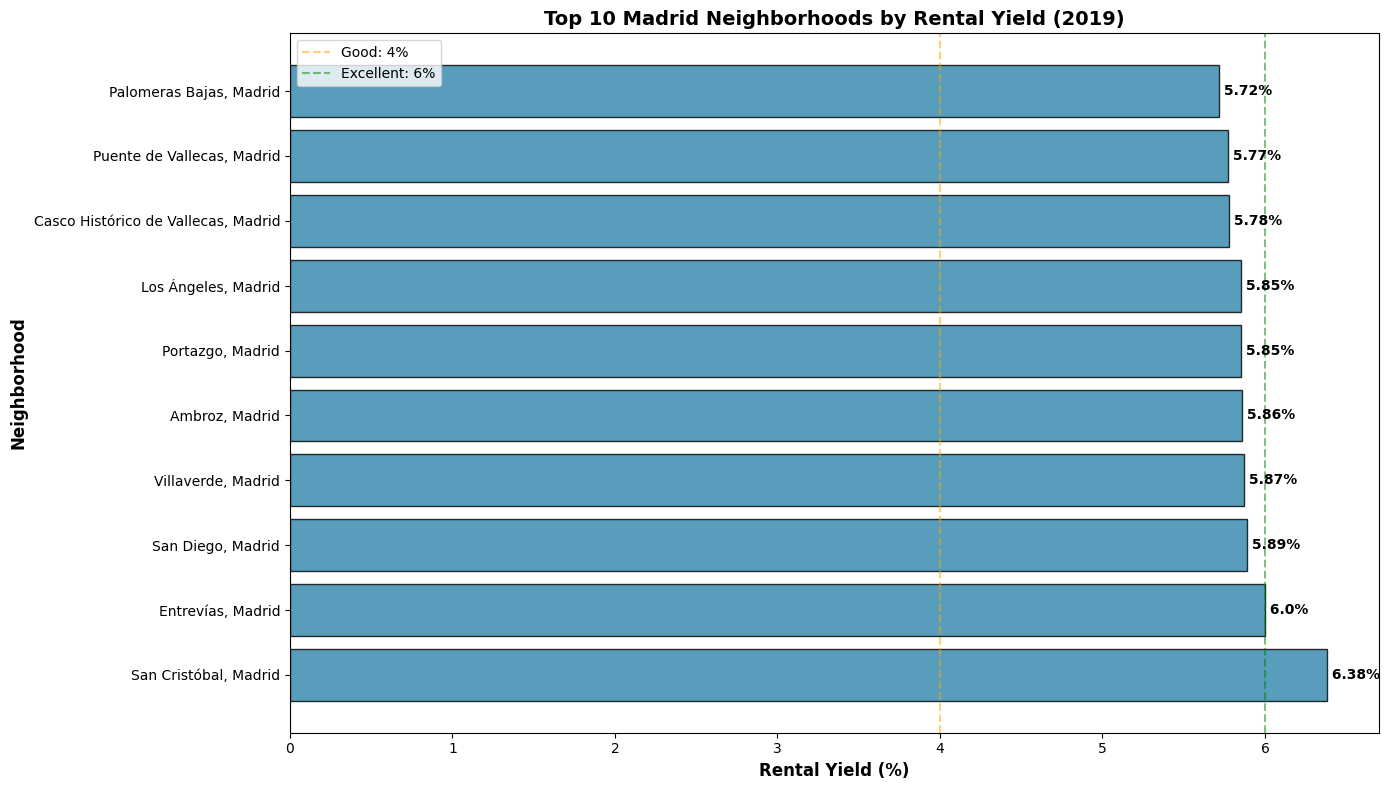

✓ Saved: madrid_rental_yields_top10.png


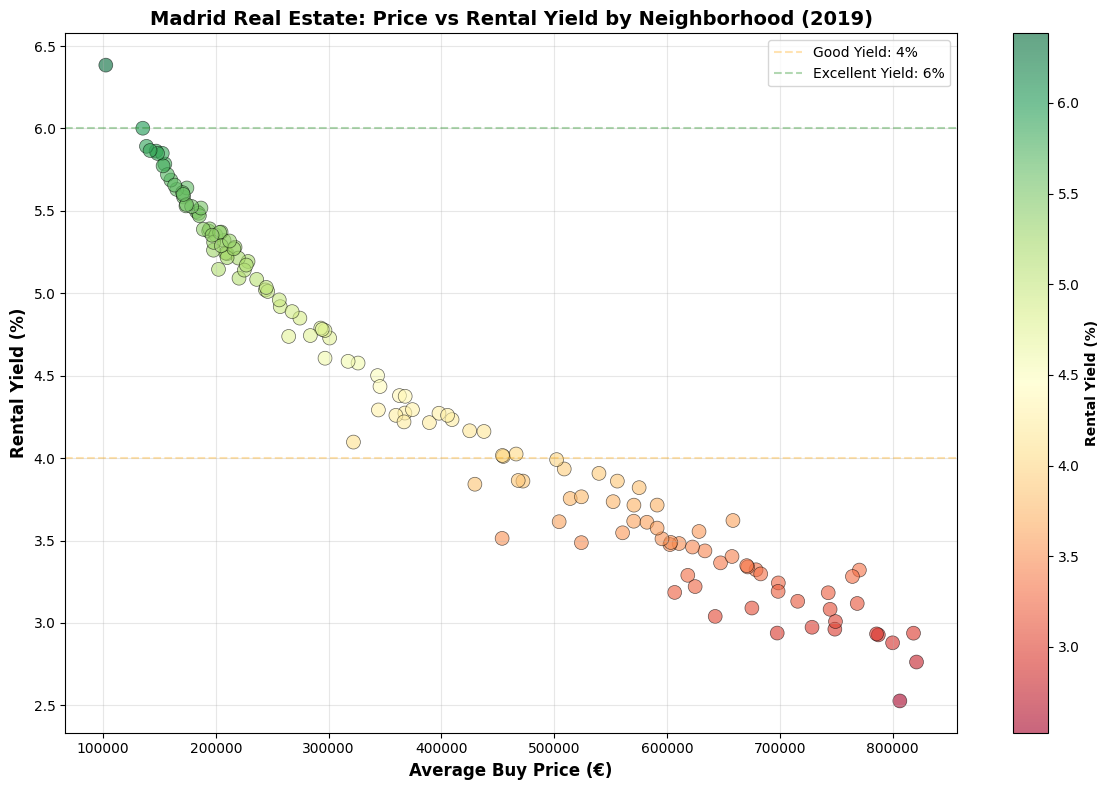

✓ Saved: madrid_price_vs_yield_scatter.png

✓✓ Visualizations complete!


In [8]:
# Visualization 1: Top 10 Rental Yields
top_10_yields = rental_yields.head(10)

plt.figure(figsize=(14, 8))
bars = plt.barh(top_10_yields['neighborhood'], top_10_yields['rental_yield_pct'],
                color='#2E86AB', edgecolor='black', alpha=0.8)

plt.xlabel('Rental Yield (%)', fontsize=12, fontweight='bold')
plt.ylabel('Neighborhood', fontsize=12, fontweight='bold')
plt.title('Top 10 Madrid Neighborhoods by Rental Yield (2019)',
          fontsize=14, fontweight='bold')

# Add value labels
for i, (idx, row) in enumerate(top_10_yields.iterrows()):
    plt.text(row['rental_yield_pct'], i, f" {row['rental_yield_pct']}%",
             va='center', fontsize=10, fontweight='bold')

# Add reference lines
plt.axvline(4, color='orange', linestyle='--', alpha=0.5, label='Good: 4%')
plt.axvline(6, color='green', linestyle='--', alpha=0.5, label='Excellent: 6%')
plt.legend()

plt.tight_layout()
plt.savefig('madrid_rental_yields_top10.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: madrid_rental_yields_top10.png")

# Visualization 2: Buy Price vs Rental Yield Scatter Plot
query_scatter = """
SELECT
    subtitle AS neighborhood,
    AVG(buy_price) AS avg_buy_price,
    (AVG(rent_price) * 12 / AVG(buy_price)) * 100 AS rental_yield
FROM properties
WHERE buy_price IS NOT NULL
  AND buy_price > 0
  AND rent_price IS NOT NULL
  AND rent_price > 0
  AND subtitle IS NOT NULL
GROUP BY subtitle
HAVING COUNT(*) >= 5
"""

scatter_data = pd.read_sql_query(query_scatter, conn)

plt.figure(figsize=(12, 8))
plt.scatter(scatter_data['avg_buy_price'], scatter_data['rental_yield'],
            s=100, alpha=0.6, c=scatter_data['rental_yield'],
            cmap='RdYlGn', edgecolors='black', linewidth=0.5)

plt.xlabel('Average Buy Price (€)', fontsize=12, fontweight='bold')
plt.ylabel('Rental Yield (%)', fontsize=12, fontweight='bold')
plt.title('Madrid Real Estate: Price vs Rental Yield by Neighborhood (2019)',
          fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Rental Yield (%)', fontsize=10, fontweight='bold')

# Add reference lines
plt.axhline(4, color='orange', linestyle='--', alpha=0.3, label='Good Yield: 4%')
plt.axhline(6, color='green', linestyle='--', alpha=0.3, label='Excellent Yield: 6%')
plt.legend()

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('madrid_price_vs_yield_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: madrid_price_vs_yield_scatter.png")

print("\n✓✓ Visualizations complete!")

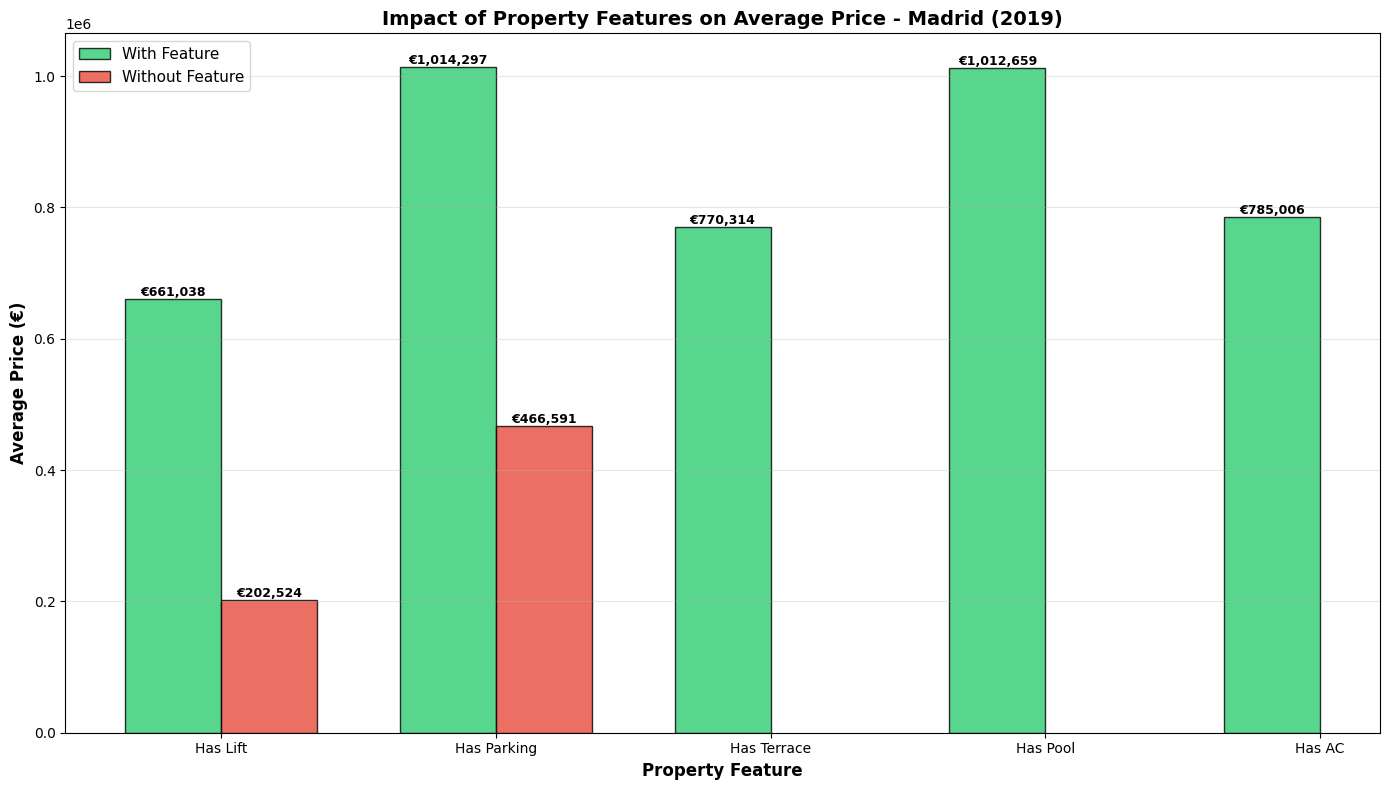

✓ Saved: madrid_features_price_impact.png

=== FEATURE PRICE PREMIUMS ===
Has Lift: +226.4% premium (€458,514 more)
Has Parking: +117.4% premium (€547,706 more)
Has Terrace: +nan% premium (€nan more)
Has Pool: +nan% premium (€nan more)
Has AC: +nan% premium (€nan more)


In [9]:
# Visualization 3: How features affect average price
feature_query = """
SELECT
    'Has Lift' AS feature,
    ROUND(AVG(CASE WHEN has_lift = 1 THEN buy_price END), 0) AS with_feature,
    ROUND(AVG(CASE WHEN has_lift = 0 THEN buy_price END), 0) AS without_feature
FROM properties
WHERE buy_price IS NOT NULL AND buy_price > 0 AND has_lift IS NOT NULL

UNION ALL

SELECT
    'Has Parking' AS feature,
    ROUND(AVG(CASE WHEN has_parking = 1 THEN buy_price END), 0) AS with_feature,
    ROUND(AVG(CASE WHEN has_parking = 0 THEN buy_price END), 0) AS without_feature
FROM properties
WHERE buy_price IS NOT NULL AND buy_price > 0 AND has_parking IS NOT NULL

UNION ALL

SELECT
    'Has Terrace' AS feature,
    ROUND(AVG(CASE WHEN has_terrace = 1 THEN buy_price END), 0) AS with_feature,
    ROUND(AVG(CASE WHEN has_terrace = 0 THEN buy_price END), 0) AS without_feature
FROM properties
WHERE buy_price IS NOT NULL AND buy_price > 0 AND has_terrace IS NOT NULL

UNION ALL

SELECT
    'Has Pool' AS feature,
    ROUND(AVG(CASE WHEN has_pool = 1 THEN buy_price END), 0) AS with_feature,
    ROUND(AVG(CASE WHEN has_pool = 0 THEN buy_price END), 0) AS without_feature
FROM properties
WHERE buy_price IS NOT NULL AND buy_price > 0 AND has_pool IS NOT NULL

UNION ALL

SELECT
    'Has AC' AS feature,
    ROUND(AVG(CASE WHEN has_ac = 1 THEN buy_price END), 0) AS with_feature,
    ROUND(AVG(CASE WHEN has_ac = 0 THEN buy_price END), 0) AS without_feature
FROM properties
WHERE buy_price IS NOT NULL AND buy_price > 0 AND has_ac IS NOT NULL
"""

features_impact = pd.read_sql_query(query_scatter, conn)

# Create grouped bar chart
features_df = pd.read_sql_query(feature_query, conn)

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(features_df))
width = 0.35

bars1 = ax.bar(x - width/2, features_df['with_feature'], width,
               label='With Feature', color='#2ECC71', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, features_df['without_feature'], width,
               label='Without Feature', color='#E74C3C', edgecolor='black', alpha=0.8)

ax.set_xlabel('Property Feature', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Price (€)', fontsize=12, fontweight='bold')
ax.set_title('Impact of Property Features on Average Price - Madrid (2019)',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(features_df['feature'])
ax.legend(fontsize=11)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'€{height:,.0f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('madrid_features_price_impact.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: madrid_features_price_impact.png")

print("\n=== FEATURE PRICE PREMIUMS ===")
for idx, row in features_df.iterrows():
    premium = ((row['with_feature'] - row['without_feature']) / row['without_feature']) * 100
    print(f"{row['feature']}: +{premium:.1f}% premium (€{row['with_feature'] - row['without_feature']:,.0f} more)")